# Requirements

- Fastest route (shortest in time), speed = 1 cell per second.
- Constraints: Overrides (rivers, sea, waterbasin, marsh)

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from implementation import *

In [2]:
def read_data(file_name):
    with open(file_name, mode='rb') as file: # b is important -> binary
        fileContent = file.read()
        rows = int(math.sqrt(len(fileContent))) 
        overrides = np.zeros((rows, rows))
        for idx in range(0, rows**2):
            i = idx // rows 
            j = idx % rows
            
            overrides[i, j] = fileContent[i*rows + j]
    return overrides

def process_data(overrides):
    overrides_values = {}
    for i in range(len(overrides)):
        for j in range(len(overrides[i])):
            value = overrides[i][j]
            if value not in overrides_values.keys():
                overrides_values[value] = 1
            else:
                overrides_values[value] += 1
    return overrides_values

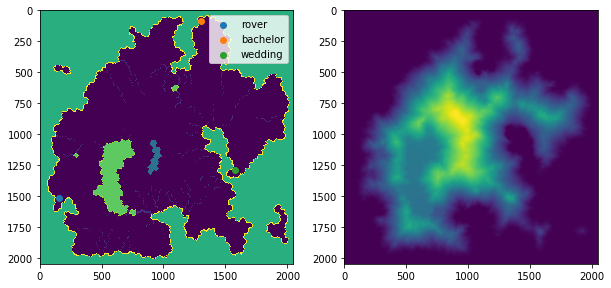

In [4]:
overrides = read_data("../assets/overrides.data")
elevation = read_data("../assets/elevation.data")

rover = (159, 1520)
bachelor = (1303, 85)
wedding = (1577, 1294)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.imshow(overrides)
ax2.imshow(elevation)

ax1.scatter(rover[0], rover[1], label='rover')
ax1.scatter(bachelor[0], bachelor[1], label='bachelor')
ax1.scatter(wedding[0], wedding[1], label='wedding')
ax1.legend()

plt.show()

In [5]:
unique_overrides = process_data(overrides)
print(unique_overrides)
unique_overrides = process_data(elevation)
print(min(unique_overrides.keys()))
print(max(unique_overrides.keys()))

euclidean_distance = np.sqrt((rover[0] - bachelor[0])**2 + (rover[1] - bachelor[1])**2) + np.sqrt((wedding[0] - bachelor[0])**2 + (wedding[1] - bachelor[1])**2)
print(euclidean_distance)

{80.0: 1722123, 128.0: 100065, 0.0: 2210031, 16.0: 35847, 112.0: 7271, 96.0: 102835, 48.0: 16132}
0.0
255.0
3074.8605680432574


The distance, without considering if it is traversable would yield 3074 cells. 

# Only obstacles

In [6]:
#from implementation import *
class SquareGrid:
    def __init__(self, scale, land):
        self.walls = []
        self.scale = scale 
        self.width = len(land) // self.scale
        self.height = len(land) // self.scale
        self.init_map(land)
    
    def in_bounds(self, id):
        (x, y) = id
        return 0 <= x < self.width and 0 <= y < self.height
    
    def passable(self, id):
        return id not in self.walls
    
    def neighbors(self, id):
        (x, y) = id
        results = [(x+1, y), (x, y-1), (x-1, y), (x, y+1), (x+1, y+1), (x-1, y-1), (x-1, y+1), (x+1, y-1)]
        if (x + y) % 2 == 0: results.reverse() # aesthetics
        results = filter(self.in_bounds, results)
        results = filter(self.passable, results)
        return results
    
    def init_map(self, data):
        for i in range(len(data)):
            for j in range(len(data[i])):
                if i % self.scale != 0 or j % self.scale != 0:
                    continue
                if data[i][j] > 0.0:
                    self.walls.append((j // self.scale, i // self.scale))
                    
    def co_to_loc(self, coordinate):
        return (coordinate[0] // self.scale, coordinate[1] // self.scale)
    
    def get_path(self, locations):
        path = np.zeros((len(locations), 2))
        for i, loc in enumerate(locations):
            path[i] = np.array([int(loc[0] * self.scale), int(loc[1] * self.scale)])
        return path
    
    def get_distance(self, path):
        return np.sqrt(sum(np.diff(path[:, 0]))**2 + sum(np.diff(path[:, 1]))**2)


In [7]:
def breadth_first_search_3(graph, start, goal):
    frontier = Queue()
    frontier.put(start)
    came_from = {}
    came_from[start] = None
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            if next not in came_from:
                frontier.put(next)
                came_from[next] = current
    
    return came_from

def get_nearest(goal, hash_map):
    def distance(x, y):
        return abs(x[0]-y[0]) + abs(x[1]-y[1])
    return min(hash_map, key=lambda x: distance(x, goal))

def get_parents(node, start, hash_map, output_lis):
    
    if node == start:
        return
    
    if node not in hash_map:
        node = get_nearest(node, hash_map)
        
    output_lis.append(node)
    next_node = hash_map[node]
    get_parents(next_node, start, hash_map, output_lis)

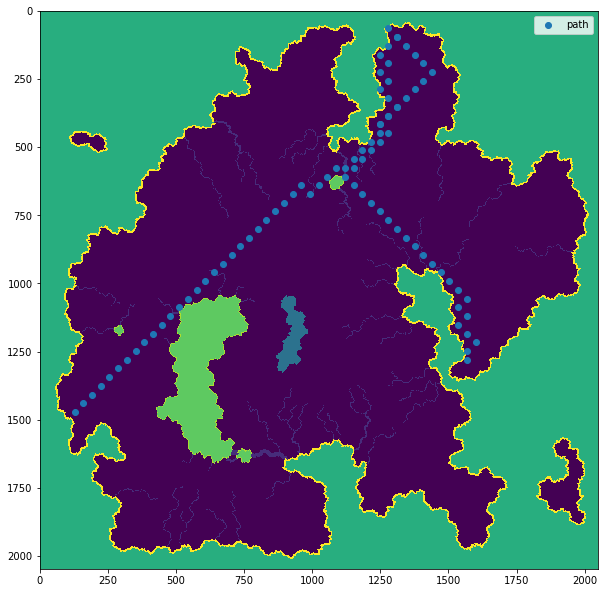

In [8]:
g = SquareGrid(32, overrides)
g.init_map(overrides)

rover = (159, 1520)
bachelor = (1303, 85)
wedding = (1577, 1294)           

start = g.co_to_loc(rover)
goal = g.co_to_loc(bachelor)

parents = breadth_first_search_3(g, start, goal)

lis = []
get_parents(goal, start, parents, lis)
path1 = g.get_path(lis)

start = g.co_to_loc(bachelor)
goal = g.co_to_loc(wedding)

parents = breadth_first_search_3(g, start, goal)

lis = []
get_parents(goal, start, parents, lis)
path2 = g.get_path(lis)

path = np.concatenate((path1, path2), axis=0)

fig, (ax3) = plt.subplots(1, 1, figsize=(10, 20))
ax3.imshow(overrides)
ax3.scatter(path[:, 0], path[:, 1], label="path")
ax3.legend()
plt.show()

In [9]:
path_by_plane = np.array([[rover[0], bachelor[0], wedding[0]], [rover[1], bachelor[1], wedding[1]]]).T
tot_dist_by_plane = np.sqrt(sum(np.diff(path_by_plane[:, 0]))**2 + sum(np.diff(path_by_plane[:, 1]))**2)

tot_dist = g.get_distance(path*32)
print("radial distance = {}".format(tot_dist_by_plane))
print("path distance = {}".format(tot_dist))

radial distance = 1435.896932234344
path distance = 1448.1546878700494


In [156]:
#elevation /= 25.5

# Also path cost (altitute)

In [10]:
import math
class GridWithWeights(SquareGrid):
    def __init__(self, scale, land):
        super().__init__(scale, land)
        self.weights = {}
    
    def cost(self, from_node, to_node):
        return self.weights.get(to_node, 1)
    
    def move_cost(self, from_node, to_node):
        distance = math.sqrt((to_node[0] - from_node[0])**2 + (to_node[1] - from_node[1])**2)
        elevation = self.weights.get(to_node, 1) - self.weights.get(from_node, 1)
        
        if elevation == 0:
            return distance
        else:
            elevation *= .03
            slope = np.arctan(elevation / distance)
            velocity = 1 - slope
            return math.sqrt(distance**2 + elevation**2) / velocity
    
    def init_costs(self, data): 
        self.weights = {}
        for i in range(len(data)):
            for j in range(len(data[i])):
                if i % self.scale != 0 or j % self.scale != 0:
                    continue

                self.weights[(j // self.scale, i // self.scale)] = data[i][j]

In [11]:
import heapq

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

def dijkstra_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current]  + graph.move_cost(current, next)# + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far

def a_star_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current]  + graph.move_cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost+ heuristic(goal, next)
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far

def reconstruct_path(came_from, start, goal):
    current = goal
    path = []
    while current != start:
        path.append(current)
        if current not in came_from:
            current = get_nearest(current, came_from)
        current = came_from[current]
    path.append(start) # optional
    path.reverse() # optional
    return path

2.522364616394043
1457.3180847021697


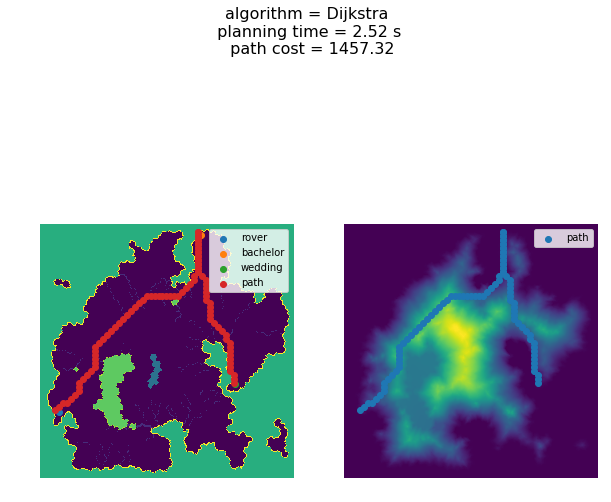

In [13]:
import time
gw = GridWithWeights(32, overrides)
gw.init_map(overrides)
gw.init_costs(elevation)
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 10))

x0 = g.co_to_loc(rover)
x1 = g.co_to_loc(bachelor)
x2 = g.co_to_loc(bachelor)
x3 = g.co_to_loc(wedding)

start_time = time.time()
came_from, cost_so_far = dijkstra_search(gw, x0, x1)
path1 = gw.get_path(reconstruct_path(came_from, start=x0, goal=x1))
came_from, cost_so_far = dijkstra_search(gw, x2, x3)
path2 = gw.get_path(reconstruct_path(came_from, start=x2, goal=x3))
path = np.concatenate((path1, path2), axis=0)

overlap = time.time() - start_time
print(overlap)
path_cost = gw.get_distance(path)#cost_so_far[get_nearest(goal, cost_so_far)]
print(path_cost)
fig.suptitle('algorithm = Dijkstra \n planning time = {:.2f} s \n path cost = {:.2f}'.format(overlap, path_cost), fontsize=16)

ax3.imshow(overrides)
ax3.scatter(rover[0], rover[1], label='rover')
ax3.scatter(bachelor[0], bachelor[1], label='bachelor')
ax3.scatter(wedding[0], wedding[1], label='wedding')
ax3.scatter(path[:, 0], path[:, 1], label="path")
ax3.axis('off')
ax3.legend()

ax4.imshow(elevation)
ax4.scatter(path[:, 0], path[:, 1], label="path")
ax4.axis('off')
ax4.legend()
plt.savefig('../results/dijkstra.png')
plt.show()

# Adding Heuristic

2.1941819190979004
46.85207498168508


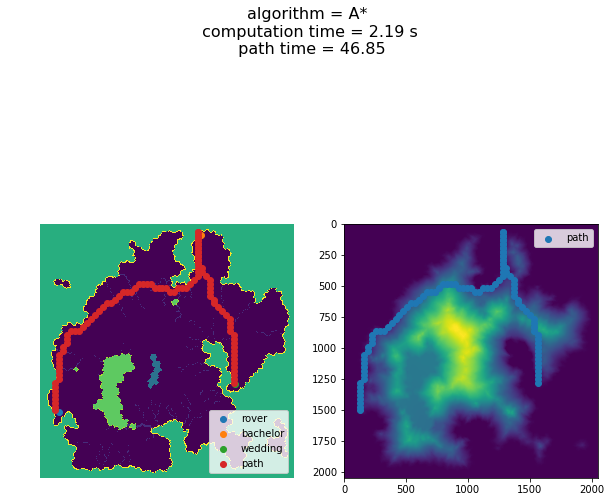

In [14]:
import time
gw = GridWithWeights(32, overrides)
gw.init_map(overrides)
gw.init_costs(elevation)
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 10))

start_time = time.time()
came_from, cost_so_far = a_star_search(gw, x0, x1)
path1 = gw.get_path(reconstruct_path(came_from, start=x0, goal=x1))
came_from, cost_so_far = a_star_search(gw, x2, x3)
path2 = gw.get_path(reconstruct_path(came_from, start=x2, goal=x3))
path = np.concatenate((path1, path2), axis=0)

overlap = time.time() - start_time
print(overlap)
path_cost = cost_so_far[get_nearest(goal, cost_so_far)]
print(path_cost)

fig.suptitle('algorithm = A* \n computation time = {:.2f} s \n path time = {:.2f}'.format(overlap, path_cost), fontsize=16)

ax3.imshow(overrides)
ax3.scatter(rover[0], rover[1], label='rover')
ax3.scatter(bachelor[0], bachelor[1], label='bachelor')
ax3.scatter(wedding[0], wedding[1], label='wedding')
ax3.scatter(path[:, 0], path[:, 1], label="path")
ax3.axis('off')
ax3.legend()

ax4.imshow(elevation)
ax4.scatter(path[:, 0], path[:, 1], label="path")
ax4.legend()
plt.savefig('../results/A*.png')
plt.show()